# **Fast ResIdual Dynamics AnalYsis**: Car tracking trajectory case


## Function Definitions

### Relu

In [1]:
from numpy.core.multiarray import result_type
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

class Relu:

  def __init__(self):
    self.mask=None
  def forward(self,x):
    self.mask= (x <= 0 )
    out=x.copy()
    out[self.mask]=0

    return out
  def backward(self, dout):
    dout[self.mask]=0
    dx=dout
    return dx

  


### Affine

In [2]:
class Affine:
  def __init__(self, W, b):
    self.W=W
    self.b=b
    self.x=None
    self.dW=None
    self.db=None

  def forward(self, x):
    self.x=x
    out= np.dot(x,  self.W)+self.b

    return out

  def backward(self, dout):
    dx= np.dot(  dout, self.W.T   )
    self.dW= np.dot( self.x.T, dout)
    self.db=np.sum(  dout, axis=0)

    return dx

  


### L2-norm

In [3]:
def l2norm( x ):
  return np.sqrt(np.sum( (x**2) )) 


### Identy with loss

In [4]:
class IdentitywithLoss:

  def __init__(self):
      self.loss = None
      self.y = None 
      self.t = None 
      self.batchsize = None
  def forward(self, y,t):
    self.y=y
    self.t=t
    self.batchsize=self.t.shape[0]

    self.loss= 0.5*np.sum(    (y-t)**2  ) /(self.batchsize)
    return self.loss

  def backward(  self, dout=1 ):
    dx = (self.y - self.t) / self.batchsize
    return dx



### Optimizers(SGD, Momentum, AdaGrad)

In [5]:
class SGD:
  def __init__(self, lr=0.05):
    self.lr=lr

  def update(self, params, grads):
    for key in params.keys():
      params[key] -= self.lr*grads[key]

In [6]:
class Momentum:
  def __init__(self, lr=0.01,  momentum=0.9):
    self.lr=lr
    self.momentum=momentum
    self.v=None
  def update(self, params, grads):
    if self.v is None:
      self.v={}
      for key , val  in params.items():
        self.v[key]=np.zeros_like(val)
    for key in params.keys():
      self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
      params[key] +=  self.v[key] 


In [7]:
class AdaGrad:
  def __init__(self, lr=0.01):
    self.lr=lr
    self.h=None
  def update(self, params, grads):
    if self.h is None:
      self.h={}
      for key , val  in params.items():
        self.h[key]=np.zeros_like(val)

    for key in params.keys():
      self.h[key] +=  grads[key]*grads[key]
      params[key] -=  self.lr*grads[key]/ (np.sqrt(self.h[key] )+1e-7 ) 
      
      

### FourLayerNet

In [8]:
from collections import OrderedDict

class FourLayerNet:

    
  def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3, output_size, weight_init_std=0.01):

    self.params={}

    self.params["W1"]=np.random.randn(input_size, hidden_size1)*np.sqrt(2 /input_size)
    self.params["b1"]=np.zeros(hidden_size1)
    self.params["W2"]=np.random.randn( hidden_size1, hidden_size2 )*np.sqrt(2/hidden_size1)
    self.params["b2"]=np.zeros(hidden_size2) 
    self.params["W3"]=np.random.randn( hidden_size2, hidden_size3 )*np.sqrt(2/hidden_size2)
    self.params["b3"]=np.zeros(hidden_size3) 
    self.params["W4"]=np.random.randn( hidden_size3, output_size )*np.sqrt(2/hidden_size3)
    self.params["b4"]=np.zeros(output_size)

    self.layers =OrderedDict()

    self.layers["Affine1"]=Affine(self.params["W1"], self.params["b1"] )
    self.layers[" Relu1"]=Relu()
    self.layers["Affine2"]=Affine(self.params["W2"], self.params["b2"] )
    self.layers[" Relu2"]=Relu()
    self.layers["Affine3"]=Affine(self.params["W3"], self.params["b3"] )
    self.layers[" Relu3"]=Relu()
    self.layers["Affine4"]=Affine(self.params["W4"], self.params["b4"] )
    #last activation is identity
    self.lastLayer= IdentitywithLoss()
    self.losslist=[0]
    
  def predict( self, x):
    for layer in self.layers.values() :
      x= layer.forward(x)
    
    return x
  def loss(self, x, t):
    y= self.predict(x)
    return self.lastLayer.forward( y, t )

  
  def gradient( self, x, t ):
    #forward
    LOSS=self.loss( x,t )
    self.losslist.append(LOSS)

    #backward
    dout=1
    dout= self.lastLayer.backward(dout) #predict and loss back

    layers=list( self.layers.values() ) #reverse process
    layers.reverse()

    for layer in layers:
      dout= layer.backward(dout)   #Affines and Relus back
    grads={}
    grads["W1"]= self.layers["Affine1"].dW
    grads["b1"]= self.layers["Affine1"].db
    grads["W2"]= self.layers["Affine2"].dW
    grads["b2"]= self.layers["Affine2"].db
    grads["W3"]= self.layers["Affine3"].dW
    grads["b3"]= self.layers["Affine3"].db
    grads["W4"]= self.layers["Affine4"].dW
    grads["b4"]= self.layers["Affine4"].db 

    return grads


  

##Main class Definitions

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from IPython import display
from time import sleep


#--------CLASS DEF-----------------
class PositioningCar:

    def __init__(self,  m, key ):
      self.m=m
      self.key=key
    
    def true_dynamics(self, x, u,t  ):
     
      g=9.81

      pos=x[0]
      vel=x[1]    

      dx= np.zeros(2)
      dx[0]= vel


      #Param-truth 
      if self.key=="param":
        m_ti=self.m  +  9*self.m*(1- np.exp(-t/120) )
        lambda_ti=np.exp(-t/120)
        dx[1]=  ( lambda_ti*u )/m_ti 
        
      #Multi-truth
      if self.key=="multi":
        dx[1]=  ( (1+vel**2)*u +   pos**2  + vel*abs(u)   )/self.m 
        
     
      #Enviro-truth
      if self.key=="enviro":
        f_air= 0.6*vel**2*np.sin(vel) 
        f_roll=  -np.sign(vel)*m*g*(  0.2*(  1 -  np.exp(-0.5*abs(vel))   )   + 0.08*abs(vel)       )
        f_duff=0.5*pos + 0.3*pos**3
        dx[1]=  (  0.6*u  - f_air -f_roll  - f_duff  )/self.m 
        
      
      
    
    

      return dx



    def model_matrix(self):
      
      A=np.array([
        [0,1],
        [0,0]
      ])

      B=np.array([
                   [0],
                   [ 1 /self.m]
      ])

      return A, B

    def lqr(A,B,Q,R):
      
      P = linalg.solve_continuous_are(A,B,Q,R)
      K=linalg.inv(R).dot(B.T).dot(P)
      E= linalg.eigvals(A-B.dot(K))

      return P, K


    def plot_graph(t, data,data2, data3,data4 ,lbls, scls, fig):

      nrow=int(np.ceil(data.shape[1]/2)) 
      ncol=min(data.shape[1],2) 
      ymin=min(min(data[:,0]),min(data2[:,0]),min(data3[:,0]),min(data4[:,0]) )-0.1
      ymax=max(max(data[:,0]),max(data2[:,0]),max(data3[:,0]),max(data4[:,0]) )+0.1
  
      ax=fig.add_subplot(nrow,ncol,1)
      
      ax.plot(t,data3[:,0]*scls[0],color="darkorange", label="FRIDAY")
      ax.plot(t,data4[:,0]*scls[0],color="green",label="Reference", linestyle ="--")
      ax.legend(bbox_to_anchor=(0.9, 0.3), loc='lower right', borderaxespad=1, fontsize=12)
      ax.set_xlabel("Time[s]")
      ax.set_ylabel(lbls[0])
      ax.grid()
      ax.set_xlim(t[0],t[-1])
      ax.set_ylim(ymin,ymax)

      plt.tight_layout()

      bx=fig.add_subplot(nrow,ncol,2) 
      bx.plot(t,data[:,0]*scls[0],color = "dodgerblue",label="State Feedback")
      bx.plot(t,data2[:,0]*scls[0],color = "salmon", label="MRAC")
      bx.plot(t,data4[:,0]*scls[0],color="green" , linestyle ="--")
      bx.legend(bbox_to_anchor=(1, 0.3), loc='lower right', borderaxespad=1, fontsize=12)
      bx.set_xlabel("Time[s]")
      bx.set_ylabel(lbls[0])
      bx.grid()
      bx.set_xlim(t[0],t[-1])
      bx.set_ylim(ymin,ymax)
      plt.tight_layout()
      
    



## Main loop

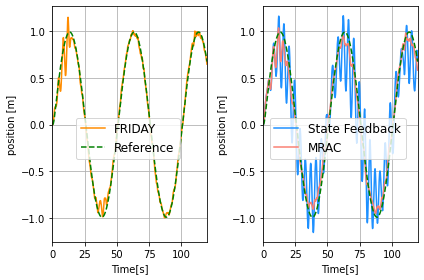

pos_fri_error= 0.04074178766453136
pos_sf_error= 0.2299936942365363
pos_mrac_error= 0.07947364526538223


In [56]:
#------common parameters-----------
m=1.5
car=PositioningCar(m, "enviro")
A, B = car.model_matrix()
Q=np.diag([20,5])
R=np.eye(1)   
P, K = PositioningCar.lqr(A,B,Q,R) 


T=120
dt=0.050 
t=np.arange(0,T,dt)

pr=0
vr=0
ur=0
Cycle =50
r = np.zeros([len(t), 2])


#----SF parameters-------
x_sf = np.zeros([len(t), 2])
u_sf = np.zeros([len(t), 1])

#----MRAC parameters-----
x_mrac = np.zeros([len(t), 2])
x_r = np.zeros([len(t), 2])
u_mrac = np.zeros([len(t), 1])
u_a = np.zeros([len(t), 1])
u_n = np.zeros([len(t), 1])

Ar= A-B@K
Br=B@K

W_hat= np.array([0,0,0 ])
gamma=0.03
sigma=0


#----FRIDAY parameters--------
invB = m
LipR= (m)**(-1/4)

x_fri = np.zeros([len(t), 2])
u_fri = np.zeros([len(t), 1])

Inputs =np.zeros([len(t), 3])
Residual = np.zeros([len(t), 1])


batch_size=100

NN=FourLayerNet(3, 50,50,50, 1)
optimizer= Momentum()

prelist = np.zeros([len(t), 1])

u1= np.random.randn(3, 1)
v1= np.random.randn(50, 1)

u2= np.random.randn(50, 1)
v2= np.random.randn(50, 1)

u3= np.random.randn(50, 1)
v3= np.random.randn(50, 1)

u4= np.random.randn(50, 1)
v4= np.random.randn(1, 1)


#----------RUN------------------------

for i in range(1, len(t) ):
  #Setpoint Regulation Test
  """
  pr=1
  vr=0
  ur=0
  """
  #Tracking Trajectory Test
  
  omega=2*np.pi/Cycle
  pr= np.sin(    omega*t[i]  )
  dpr=omega* np.cos( omega*t[i] )
  ur = - m*omega**2*np.sin(omega*t[i])
  
  
  r[i,:] = np.array([ pr,vr ])
  dist=1*np.random.randn(1)

#---------States Feedback Controller---------------------
  u_sf[i]= -np.dot(K,x_sf[i-1,:]-r[i,:]) + ur  #1. Decide control input

  dx_sf  = car.true_dynamics(x_sf[i-1, :], u_sf[i]+dist , t[i] ) #2. Input to unknown dynamics and get dx

  x_sf[i,:]=x_sf[i-1,:]+ dx_sf*dt #3. Update state

#-------Model Reference Adaptive Controller------------

  u_n[i]= -np.dot(K,x_mrac[i-1,:]-r[i,:]) + ur

  sigma= np.append(  x_mrac[i-1,:],  u_n[i]  ) #ADAPT
  e=x_mrac[i-1,:]-x_r[i-1,:]
  dW= gamma*sigma*(e@P@B)
  W_hat =W_hat + dW*dt
  u_a[i] = - W_hat@sigma
  
  u_mrac[i] = u_n[i] + u_a[i] #1. Decide control input

  dx_mrac = car.true_dynamics(x_mrac[i-1, :], u_mrac[i]+dist, t[i] )  #2. Input to unknown dynamics and get dx
  dx_r =  Ar@x_r[i-1, :] +   Br@r[i,:]  + B.T*ur

  x_mrac[i,:]=x_mrac[i-1,:]+ dx_mrac*dt #3. Update state
  x_r[i,:]=x_r[i-1,:]+ dx_r*dt

#-----------Fast ResIdual Dynamics AnalYsis Controller---------------
 

  pastdata= np.append(x_fri[i-1,:] , u_fri[i-1]) 
  R_hat =NN.predict( pastdata ) #GUESS
  prelist[i] = R_hat

  u_fri[i]=  -np.dot(K,x_fri[i-1,:]-r[i,:] )  + ur - invB*R_hat   #1. Decide control input

  dx_fri  = car.true_dynamics(x_fri[i-1, :], u_fri[i]+dist , t[i] )  #2. Input to unknown dynamics and get dx
  
  x_fri[i,:]=x_fri[i-1,:]+ dx_fri*dt #3. Update state

  Inputs[i,:]=np.append(x_fri[i-1,:] , u_fri[i] ) #LEARN
  Residual[i] = dx_fri[1]  - 1/m* u_fri[i]

  batch_mask=np.random.choice(i , batch_size)
  x_batch=Inputs[batch_mask]
  t_batch= Residual[batch_mask]

  v1=  (NN.params["W1"].T@u1) /  l2norm( NN.params["W1"].T@u1) 
  u1= (NN.params["W1"]@v1 )/ l2norm(  NN.params["W1"]@v1  )
  sigma1 = u1.T@NN.params["W1"]@v1
  NN.params["W1"]  *= LipR/sigma1

  v2=  (NN.params["W2"].T@u2) /  l2norm( NN.params["W2"].T@u2)
  u2= (NN.params["W2"]@v2 )/ l2norm(  NN.params["W2"]@v2  )
  sigma2 = u2.T@NN.params["W2"]@v2
  NN.params["W2"]  *= LipR/sigma2

  v3=  (NN.params["W3"].T@u3) /  l2norm( NN.params["W3"].T@u3)
  u3= (NN.params["W3"]@v3 )/ l2norm(  NN.params["W3"]@v3  )
  sigma3 = u3.T@NN.params["W3"]@v3
  NN.params["W3"]  *= LipR/sigma3

  v4=  (NN.params["W4"].T@u4) /  l2norm( NN.params["W4"].T@u4)
  u4= (NN.params["W4"]@v4 )/ l2norm(  NN.params["W4"]@v4  )
  sigma4 = u4.T@NN.params["W4"]@v4
  NN.params["W4"]  *= LipR/sigma4


  grads=NN.gradient(x_batch, t_batch) 
  params=NN.params
  optimizer.update(params, grads)
  
#--------------PLOT---------------

plt.close("all")

lbls= ('position [m]', 'velosity [m/s]')
scls = (1, 1)
base_fig = plt.figure()
PositioningCar.plot_graph(t,  x_sf, x_mrac,x_fri, x_r ,lbls, scls, base_fig)

plt.show()

FRI=abs(x_fri[:,0]- x_r[:,0])
print("pos_fri_error=",np.average( FRI))
SF=abs(x_sf[:,0]- x_r[:,0])
print("pos_sf_error=",np.average( SF ))
MRAC=abs(x_mrac[:,0]- x_r[:,0])
print("pos_mrac_error=",np.average( MRAC ))


### Prediction Performance


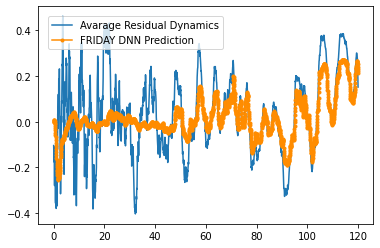

In [55]:
from scipy.ndimage import gaussian_filter1d

v = np.ones(10)/10          
y1 = np.convolve(Residual[:,0], v, mode='same')   #moving average of residual dynamics
pre1=prelist
plt.plot(t, y1, label="Avarage Residual Dynamics")
plt.plot(t, pre1, color="darkorange", marker=".",label="FRIDAY DNN Prediction") #plot

plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=10)
plt.show()